# Homework 1 - Q5

### Author: Pushkar Vengurlekar

In [1]:
# Data Handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Decision Tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import graphviz

# Models
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_validate, train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data Import and Cleaning

In [3]:
colnames = ["id", "diagnosis"]+list(range(3,33))
raw_data = pd.read_csv("wdbc.data", sep = ',', names = colnames)

In [4]:
raw_data['diagnosis'].unique()

array(['M', 'B'], dtype=object)

**Malignant(M) and Benign(B) are the two target variables to be predicted.**

In [6]:
# Checking if Dataset is imbalanced
raw_data.groupby('diagnosis').count().iloc[:, :1]

,id
diagnosis,
B,357
M,212


The Dataset does not look imbalanced. We can proceed with The classifiers without accounting for the imbalances in class.

**We change the Labels from Malignant as 1 and Benign as 0**

In [7]:
raw_data['diagnosis'] = raw_data['diagnosis'].map({'B':0, 'M':1})

In [5]:
# Split the data into its X and Y components
X = raw_data.iloc[:, 2:32]
y = np.array(raw_data.iloc[:, 1])

# Decision Trees

In [6]:
# Defining the model
dt = DecisionTreeClassifier()
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.3, random_state = 123)

dt.fit(x_train, y_train)
print("Accuracy: ", round(accuracy_score(y_test, dt.predict(x_test))*100, 2))

Accuracy:  96.49


In [7]:
dt.fit(x_train, y_train).decision_function(x_test)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'decision_function'

###  Model Performance for different Tree Depths 

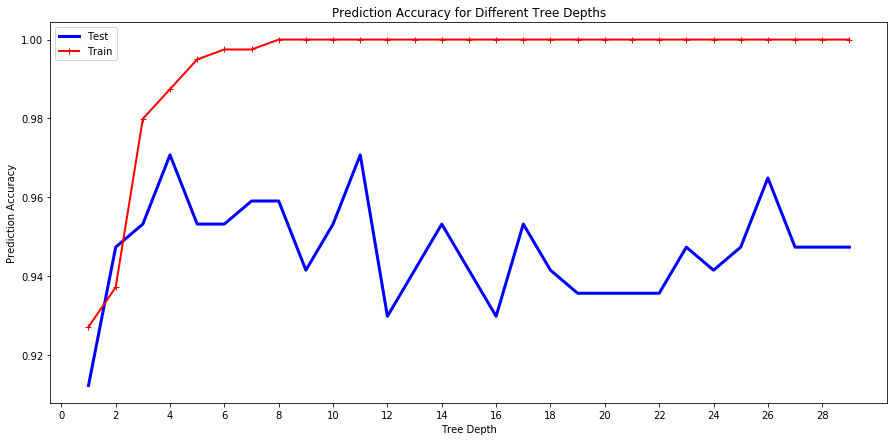

In [66]:
test_acc = []
train_acc = []
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.3, random_state = 123)

for i in range(1,30):
    dt = DecisionTreeClassifier(max_depth =i)
    dt.fit(x_train, y_train)
    test_acc.append(accuracy_score(y_test, dt.predict(x_test)))
    train_acc.append(accuracy_score(y_train, dt.predict(x_train)))

plt.figure(figsize=(15,7))
plt.plot(range(1, 30),test_acc,"b-", linewidth = 3, label = "Test")
plt.plot(range(1, 30), train_acc,"r-+", linewidth = 2, label = "Train")
plt.legend()
plt.xlabel("Tree Depth")
plt.ylabel("Prediction Accuracy")
plt.title("Prediction Accuracy for Different Tree Depths")
plt.xticks(range(0,30,2))
plt.show()

In the above graph, we observe How the model performs for different tree depths. 

For the initial values, (depth <3) we see that the model is underfitting as it is generalizing most of the values. Here, We gert a low accuracy for both the train and test values. Also the test test data score increases rapidly with increase in depth. 

For depth>7, we see that the model overfits the data by matching random noise. The training data accuracy hits 100% whereas test accuracy drops to <94 percent. The  correct depth for the parameters lies between 3 to 7.

###  Model Selection

We select the best model using GridSearch method. We split datasets into 5 parts to perform the cross validation. 

Our objective in creating the best model is to Improve the **recall (Reduce the number of false negetives)** for the cancer prediction. We choose this as target metric as we do not want to predict maximum number of positive cancer cases. 

The cost of predicting a patient not to have cancer when he actually does is much higher than the cost of predicting a patient to have cancer but not actually have it.

In [35]:
clf = DecisionTreeClassifier(random_state = 10)
p_grid = {'max_depth':list(range(1,30)), 
          'criterion':['gini', 'entropy'],
          'min_samples_split':list(range(2,30))}

classifier = GridSearchCV(clf, param_grid=p_grid, cv = 10, scoring='recall', n_jobs = 10)
classifier.fit(x_train, y_train)
print("Best Score:",classifier.best_score_)
print("Best Parameters:",classifier.best_params_)

Best Score: 0.9302703996171332
Best Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 2}


From Gridsearch, we get the best Tree Depth to be **6**, **2** min sample split and **entropy** to be the desitable hyperparameters.

#### We then proceed to Get the model accuracy using cross validation.

In [36]:
# Accuracy for the Parameters using Cross validation
clf = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split = 2)
DT_Scores = cross_val_score(clf, x_train, y_train, cv = 10)

print("Mean Score:", np.mean(DT_Scores))
print("Std Deviation:", np.std(DT_Scores))

Mean Score: 0.9417761100687929
Std Deviation: 0.056238219588495425


#### Checking Model Performance on Holdouot Data:

In [37]:
Decision_tree = clf.fit(x_train, y_train)
y_pred = Decision_tree.predict(x_test)
accuracy_score(y_test, y_pred)

0.9415204678362573

**Decision Tree Performs Quite well with 95.9% accuracy. However, we are interested in Recall score for the prediction**

## Decision Tree

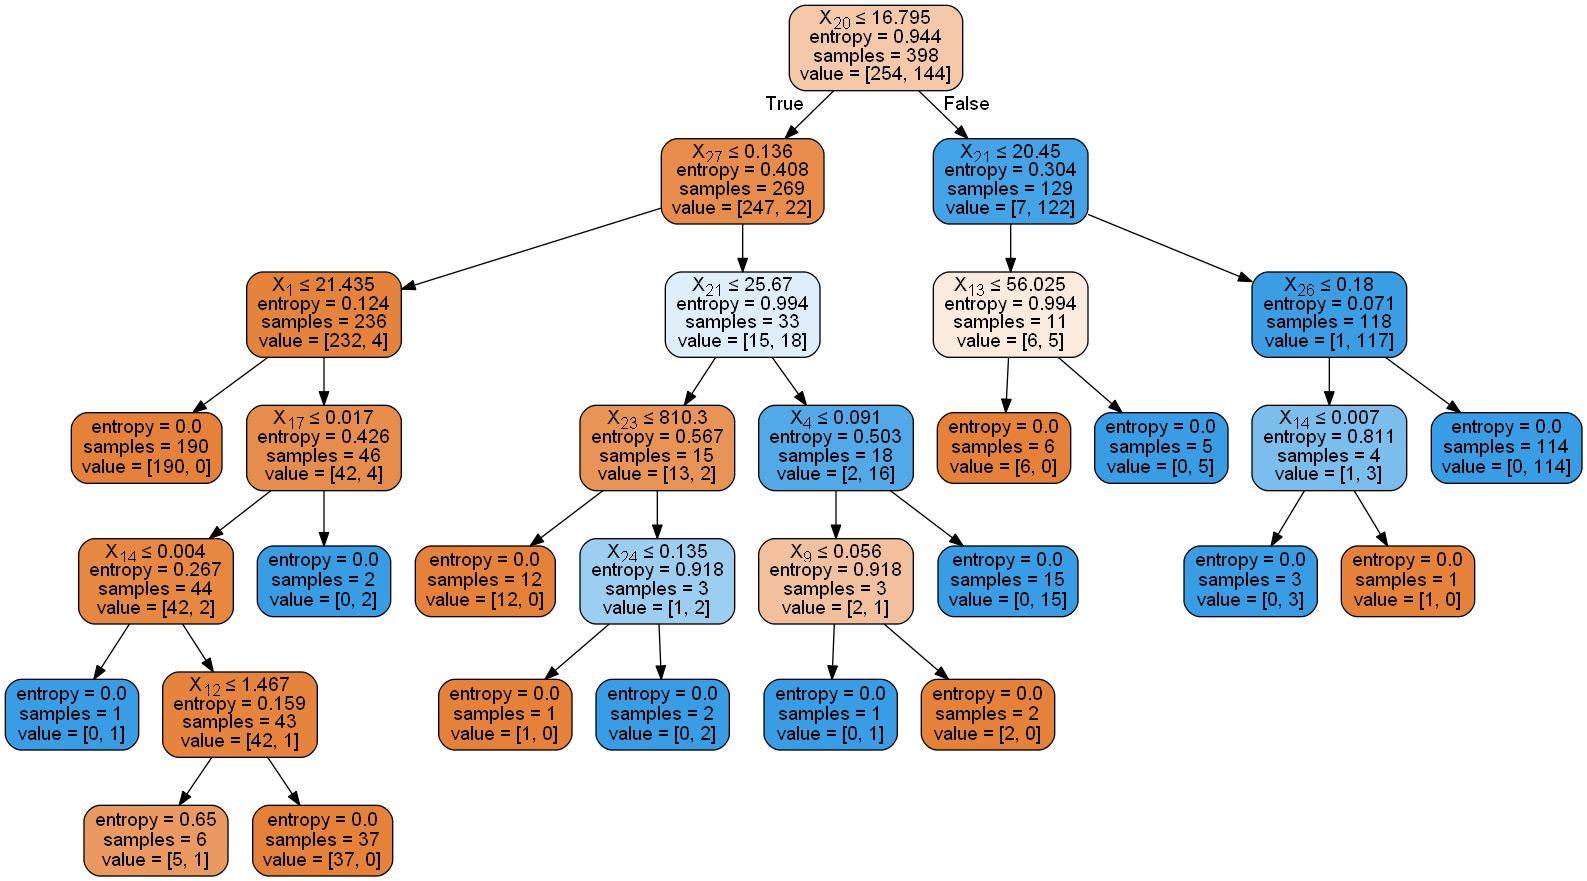

In [15]:
dot_data = StringIO()
export_graphviz(Decision_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

###  Confusion Matrix

In [38]:
# Confusion Matrix and Other parameters
matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(matrix)
print('\n')
# print("Precision:", round(matrix[0][0]/np.sum(matrix[0])*100,2), "%")
# print("Recall:", round(matrix[0][0]/np.sum(matrix[:,0])*100,2), "%")
# print("Accuracy Score:", round(accuracy_score(y_test, y_pred)*100,2), "%")

print("Precision:", round(precision_score(y_test, y_pred, pos_label=1)*100,2), "%")
print("Recall:", round(recall_score(y_test, y_pred, pos_label=1)*100,2), "%")
print("f1_score:", round(f1_score(y_test, y_pred, pos_label=1)*100,2), "%")
print("Accuracy Score:", round(accuracy_score(y_test, y_pred)*100,2), "%")

Confusion matrix
[[99  4]
 [ 6 62]]


Precision: 93.94 %
Recall: 91.18 %
f1_score: 92.54 %
Accuracy Score: 94.15 %


We observe that out of 68 Malignant cases, our model correctly identifies 65. The Model has a recall of 95.59%.

# KNN Classifier

In [39]:
# Defining the model
knn = KNeighborsClassifier()
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.3, random_state = 123)

knn.fit(x_train, y_train)
print("Accuracy: ", round(accuracy_score(y_test, knn.predict(x_test))*100, 2))

Accuracy:  92.98


###  Model Performance for different number of Neighbors

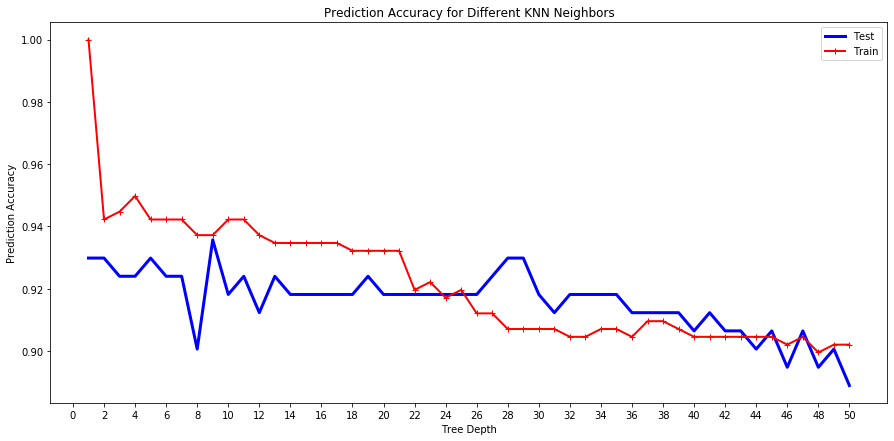

In [40]:
test_acc = []
train_acc = []
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.3, random_state = 123)

for i in range(1,51):
    knn = KNeighborsClassifier(n_neighbors= i)
    knn.fit(x_train, y_train)
    test_acc.append(accuracy_score(y_test, knn.predict(x_test)))
    train_acc.append(accuracy_score(y_train, knn.predict(x_train)))

plt.figure(figsize=(15,7))
plt.plot(range(1, 51),test_acc,"b-", linewidth = 3, label = "Test")
plt.plot(range(1, 51), train_acc,"r-+", linewidth = 2, label = "Train")
plt.legend()
plt.xlabel("Tree Depth")
plt.ylabel("Prediction Accuracy")
plt.title("Prediction Accuracy for Different KNN Neighbors")
plt.xticks(range(0,52,2))
plt.show()

In the above graph, we observe How the model performs for different Number of Neighbors.

For the initial values, (neighbors 1 and 2) we see that the model is overfitting as it is picking up random noise from the data. Here, We gert a high accuracy for train dataset But a very low accuracy for test. 

For depth>20, we see that the model underfits the data by generalizing. The training data accuracy drops lower than  whereas test accuracy drops to <94 percent. The  correct depth for the parameters lies between 2 and 20.

###  Model Selection

We select the best model using GridSearch method. We split datasets into 5 parts to perform the cross validation. 

Our objective in creating the best model is to Improve the **recall (Reduce the number of false negetives)** for the cancer prediction. We choose this as target metric as we do not want to predict maximum number of positive cancer cases. 

The cost of predicting a patient not to have cancer when he actually does is much higher than the cost of predicting a patient to have cancer but not actually have it.

In [41]:
clf = KNeighborsClassifier()
p_grid = {'n_neighbors':list(range(1,50)), 'weights':['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

classifier = GridSearchCV(clf, param_grid=p_grid, cv = 10, scoring='recall', n_jobs = 8)
classifier.fit(x_train, y_train)
print("Best Score:",classifier.best_score_)
print("Best Parameters:",classifier.best_params_)

Best Score: 0.874670973917205
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'distance'}


From Gridsearch, we get the best Algorithm to be **auto**,  **distance** as weights and **8** neighbors.

#### We then proceed to Get the model accuracy using cross validation.

In [42]:
# Accuracy for the Parameters using Cross validation
clf = KNeighborsClassifier(weights = 'distance', algorithm = 'auto', n_neighbors=8)
KNN_Scores = cross_val_score(clf, x_train, y_train, cv = 10)

print("Mean Score:", np.mean(KNN_Scores))
print("Std Deviation:", np.std(KNN_Scores))

Mean Score: 0.934208880550344
Std Deviation: 0.026568146949144056


#### Checking Model Performance on Holdouot Data:

In [43]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.9239766081871345

KNN Classifier has 94.15% accuracy. However, we are interested in Recall score for the prediction. 

###  Confusion Matrix

In [44]:
# Confusion Matrix and Other parameters
matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(matrix)
print('\n')

print("Precision:", round(precision_score(y_test, y_pred, pos_label=1)*100,2), "%")
print("Recall:", round(recall_score(y_test, y_pred, pos_label=1)*100,2), "%")
print("f1_score:", round(f1_score(y_test, y_pred, pos_label=1)*100,2), "%")
print("Accuracy Score:", round(accuracy_score(y_test, y_pred)*100,2), "%")

Confusion matrix
[[100   3]
 [ 10  58]]


Precision: 95.08 %
Recall: 85.29 %
f1_score: 89.92 %
Accuracy Score: 92.4 %


We observe that out of 68 Malignant cases, our model correctly identifies 58. The Model has a recall of 85.29%.

# Logistic Regression

In [45]:
# Defining the model
knn = LogisticRegression(random_state = 10)
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.3, random_state = 123)

knn.fit(x_train, y_train)
print("Accuracy: ", round(accuracy_score(y_test, knn.predict(x_test))*100, 2))

Accuracy:  98.25


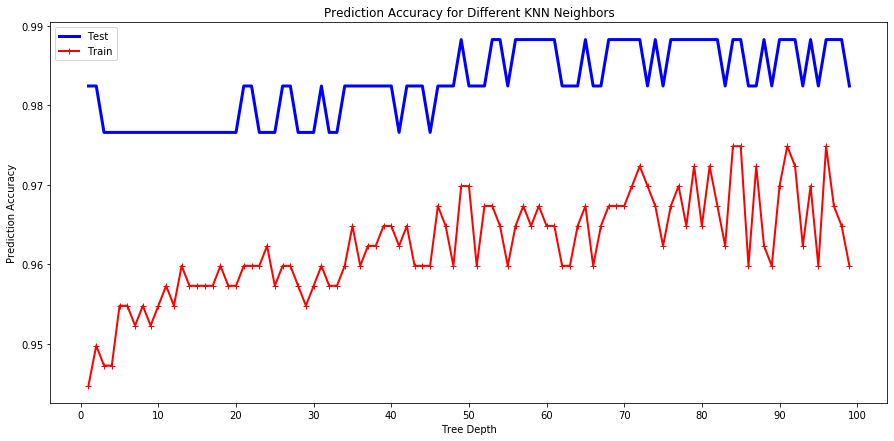

In [70]:
test_acc = []
train_acc = []
x_train, x_test, y_train, y_test = train_test_split(X ,y, test_size = 0.3, random_state = 123)

for i in range(1,100):
    Logit = LogisticRegression(C= i)
    Logit.fit(x_train, y_train)
    test_acc.append(accuracy_score(y_test, Logit.predict(x_test)))
    train_acc.append(accuracy_score(y_train, Logit.predict(x_train)))

plt.figure(figsize=(15,7))
plt.plot(range(1, 100),test_acc,"b-", linewidth = 3, label = "Test")
plt.plot(range(1, 100), train_acc,"r-+", linewidth = 2, label = "Train")
plt.legend()
plt.xlabel("Tree Depth")
plt.ylabel("Prediction Accuracy")
plt.title("Prediction Accuracy for Different KNN Neighbors")
plt.xticks(range(0,102,10))
plt.show()

###  Model Selection

We select the best model using GridSearch method. We split datasets into 5 parts to perform the cross validation. 

Our objective in creating the best model is to Improve the **recall (Reduce the number of false negetives)** for the cancer prediction. We choose this as target metric as we do not want to predict maximum number of positive cancer cases. 

The cost of predicting a patient not to have cancer when he actually does is much higher than the cost of predicting a patient to have cancer but not actually have it.

In [46]:
clf = LogisticRegression(random_state=10)
p_grid = {'penalty':['l1','l2'], 'C':list(np.arange(1.0, 10.0, 0.2))}

classifier = GridSearchCV(clf, param_grid=p_grid, cv = 10, scoring='recall', n_jobs = 8)
classifier.fit(x_train, y_train)
print("Best Score:",classifier.best_score_)
print("Best Parameters:",classifier.best_params_)

Best Score: 0.9302703996171335
Best Parameters: {'C': 9.399999999999999, 'penalty': 'l1'}


From Gridsearch, we get the best hyperparameters for the model.

#### We then proceed to Get the model accuracy using cross validation.

In [47]:
# Accuracy for the Parameters using Cross validation
clf = LogisticRegression(penalty = 'l1', C = 9.40)
Logistic_Scores = cross_val_score(clf, x_train, y_train, cv = 10)

print("Mean Score:", np.mean(Logistic_Scores))
print("Std Deviation:", np.std(Logistic_Scores))

Mean Score: 0.949343339587242
Std Deviation: 0.0363642070296601


#### Checking Model Performance on Holdouot Data:

In [48]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.9766081871345029

Our Model has 97.6% accuracy. However, we are interested in Recall score for the prediction. 

###  Confusion Matrix

In [49]:
# Confusion Matrix and Other parameters
matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(matrix)
print('\n')

print("Precision:", round(precision_score(y_test, y_pred, pos_label=1)*100,2), "%")
print("Recall:", round(recall_score(y_test, y_pred, pos_label=1)*100,2), "%")
print("f1_score:", round(f1_score(y_test, y_pred, pos_label=1)*100,2), "%")
print("Accuracy Score:", round(accuracy_score(y_test, y_pred)*100,2), "%")

Confusion matrix
[[102   1]
 [  3  65]]


Precision: 98.48 %
Recall: 95.59 %
f1_score: 97.01 %
Accuracy Score: 97.66 %


We observe that out of 68 Malignant cases, our model correctly identifies 65. The Model has a recall of 95.59%.

# Model Selection

In our quest to select the best model out of the three, **Logistic** Model described in the third section of this analysis turns to be the best amongst the three. <br>
We are more inclined to minimize false negetives in our prediction since the cost of classifying a cancer as not to be present is way higher than flagging a non-cancer case as positive. 

The three models have following Metrics:

**Decision Trees**<br>
Precision: 94.2 %<br>
Recall: 95.59 %<br>
f1_score: 92.54 % <br>
Accuracy Score: 95.91 %

**K-Nearest_Neighbors Classification**<br>
Precision: 95.08 %<br>
Recall: 85.29 %<br>
f1_score: 89.92 % <br>
Accuracy Score: 92.4 %

**Logistic Regression**<br>
Precision: 98.48 %<br>
Recall: 95.59 %<br>
f1_score: 97.01 % <br>
Accuracy Score: 97.66 %

Both Logistic Regression and Decision Trees have high Desirable metric:Recall. However, Logistic regression has higher accuracy as well as precision which will lead to fewer False Positive cases. 

We lesect Logistic Regression as final Prediction model